In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready, config

from algos.ppo import PPO_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [84]:
# Defining all constants

KAPPA = 20.0
CHI = 0.65 * 2 * jnp.pi
N_MAX = 233
N_DEFAULT = 43 # assume all measurement are till steady-state, ie around 10/kappa = 400ns
mu_default = jnp.sqrt(N_MAX / N_DEFAULT)
amp_default = 1/mu_default
GAMMA_PHOTON = 1/2000
GAMMA_MEAS = 1/100
INIT_FID = 1 - 1e-3
SNR_SCALE = 2.3
STATE_STD = 1/jnp.sqrt(2)

In [87]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/100
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 1e-2
snr_scale_factor = 2.3
gamma_I = 1/100
num_t1 = 8.0
photon_gamma = 1/2000
init_fid = 1 - 1e-3
photon_weight = 4.0

batchsize = 64
num_envs = 8
num_updates = 1000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 256,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [88]:
from envs.photon_langevin_env import BatchedPhotonLangevinReadoutEnv

b_size = 2

env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=b_size,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight
)

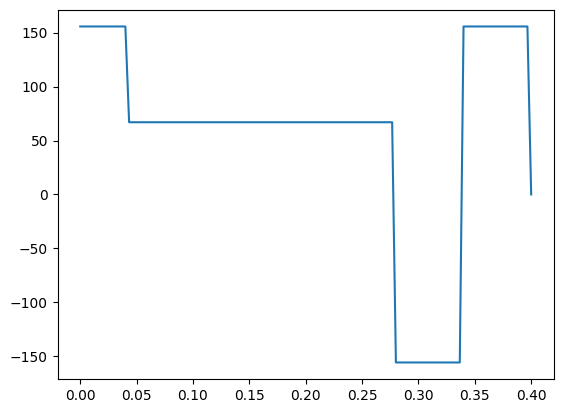

In [91]:
ts_action = env.ts_action

tau_1 = 0.042
tau_2 = 0.280
tau_3 = 0.340 # 153 is optimal
tau_4 = 0.400

action = jnp.heaviside(tau_1 -  ts_action, 0.)
action += 1 / env.mu * (jnp.heaviside(tau_2 - ts_action, 0.) - jnp.heaviside(tau_1 - ts_action, 0.))
action -= (jnp.heaviside(tau_3 - ts_action, 0.) - jnp.heaviside(tau_2 - ts_action, 0.))
action += (jnp.heaviside(tau_4 - ts_action, 0.) - jnp.heaviside(tau_3 - ts_action, 0.))

action *= env.a0 * env.mu

plt.plot(ts_action, action)
plt.show()

Min Photon: 0.22304440834930525
Time of Min Photon: 358.88888888888886ns


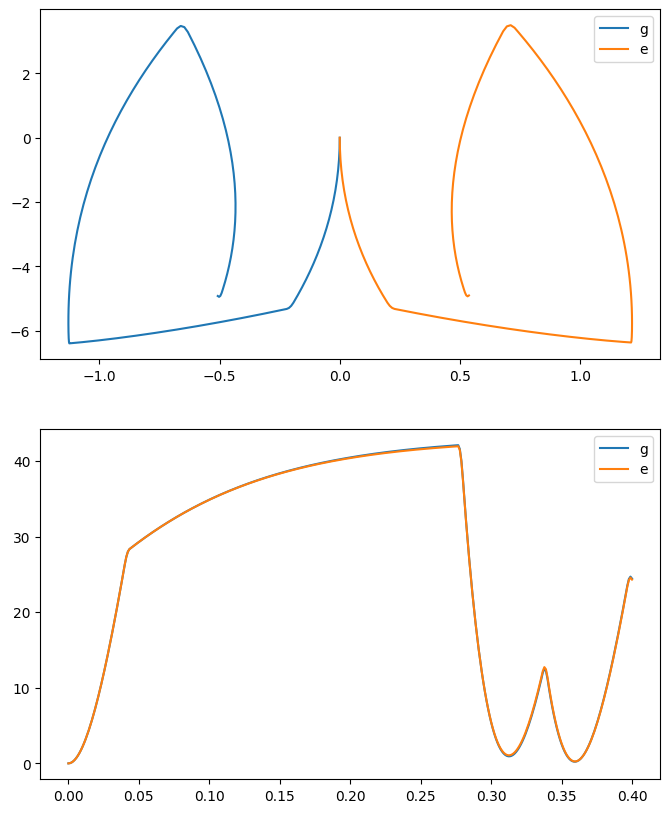

In [92]:
res_g_real, res_g_imag, res_e_real, res_e_imag = env.calc_results(action).T
res_g = res_g_real + 1.0j * res_g_imag
res_e = res_e_real + 1.0j * res_e_imag
photon_g = jnp.abs(res_g) ** 2
photon_e = jnp.abs(res_e) ** 2

min_photon = jnp.min(photon_g[45:])
print(f"Min Photon: {min_photon}")
print(f"Time of Min Photon: {env.ts_sim[45 + jnp.argmin(photon_g[45:])]*1000}ns")

fig, ax = plt.subplots(2, figsize=(8.0, 10.0))

ax[0].plot(res_g.real, res_g.imag, label='g')
ax[0].plot(res_e.real, res_e.imag, label='e')
ax[0].legend()

ax[1].plot(env.ts_sim, photon_g, label='g')
ax[1].plot(env.ts_sim, photon_e, label='e')
ax[1].legend()

plt.show()

## A4R Measurement

corresponding tau 3: 0.060000000000000005


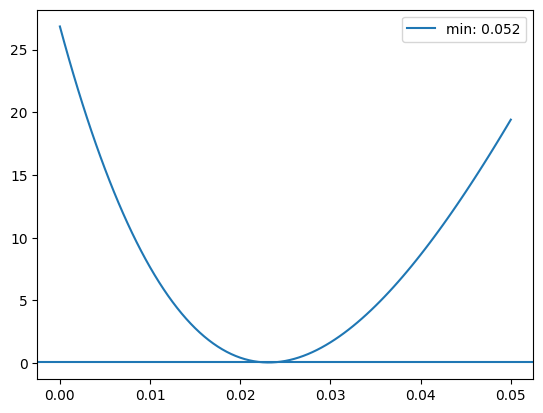

In [83]:
def photon_func(tau_3, ts):
    n = n0
    u = res_amp_scaling
    k = KAPPA
    c = CHI
    return n * (
        u**2 + 4 * u**2 * jnp.exp(-k * ts) + (u + 1)**2*jnp.exp(-k * (ts + tau_3)) 
        - 4 * u ** 2 * jnp.exp(-0.5*k*ts) * jnp.cos(0.5 * c * ts)
        + 2 * u * (u + 1) * jnp.exp(-0.5 * k * (ts + tau_3)) * jnp.cos(0.5 * c * (ts + tau_3))
        - 4 * u * (u + 1) * jnp.exp(-k * ts) * jnp.exp(-0.5 * k * tau_3) * jnp.cos(0.5 * chi * tau_3))

tau_3 = jnp.linspace(0.05, 0.1, 51).reshape(-1, 1)
ts = jnp.linspace(0., 0.05, 101).reshape(1, -1)

big_photons = photon_func(tau_3, ts)
min_photons = jnp.min(big_photons, axis=-1)

ts = ts.flatten()
tau_3 = tau_3.flatten()

ind = 10
print(f"corresponding tau 3: {tau_3[ind]}")

plt.plot(ts, big_photons[ind])
plt.axhline(y=min_photons[ind], label=f'min: {int(1e3*min_photons[ind])/1e3}')
plt.legend()
plt.show()

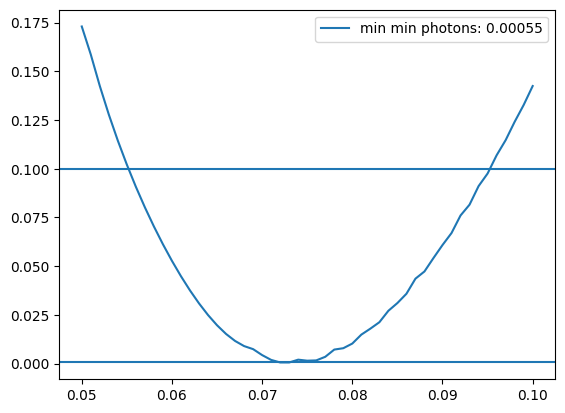

In [64]:
plt.plot(tau_3, min_photons)
plt.axhline(y=jnp.min(min_photons), label=f'min min photons: {int(1e5*jnp.min(min_photons))/1e5}')
plt.axhline(y=0.1)
plt.legend()
plt.show()

0.000552735453911879


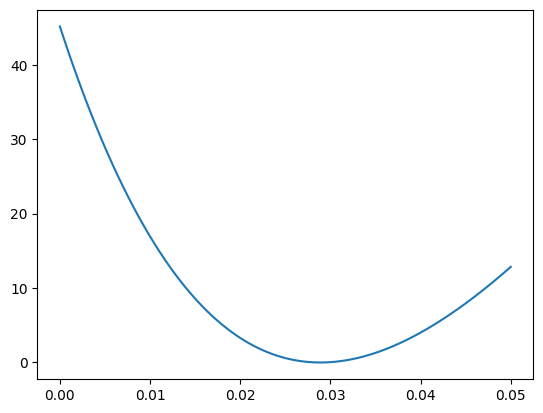

In [66]:
p_vals = big_photons[jnp.argmin(min_photons)]

plt.plot(ts, p_vals)
print(jnp.min(p_vals))